In [1]:
!git clone https://github.com/zxzhaixiang/QMDB

Cloning into 'QMDB'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 557 (delta 114), reused 141 (delta 73), pack-reused 354
Receiving objects: 100% (557/557), 267.02 MiB | 37.86 MiB/s, done.
Resolving deltas: 100% (289/289), done.
Checking out files: 100% (92/92), done.


In [0]:
datapath = './QMDB/data/processed_data/'
#datapath = './../data/processed_data/'

In [3]:
!pip install hiddenlayer

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
savepath = './gdrive/My Drive/'

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import pickle
import random
import scipy.signal as sp_signal
import pandas as pd
import seaborn as sns
from datetime import datetime
import re

from imblearn.over_sampling import RandomOverSampler

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE
import scipy.stats

from IPython.display import HTML, display

import hiddenlayer as hl
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from torch.autograd import Variable
from torchvision import transforms

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device is ", device)

Device is  cuda


In [10]:
torch.__version__

'1.1.0'

## Loading data and prepare data loader

In [11]:
print('loading raw rating data..',end='')
rating_df = pd.read_csv(os.path.join(datapath,'ratings_with_kws.csv'), compression='gzip')

#print('Done\n {} total rating record loaded\n'.format(rating_df.shape[0]))

userIds = rating_df['userId'].unique()

loading raw rating data..

In [0]:
user_df = rating_df.groupby('userId', as_index=False).agg({
                      'movieId': [('num_movie_rated','count')],
                      'rating': [('user_ave_rating','mean'),('user_std_rating','std')]}).fillna(0)
user_df.columns.set_levels([item if item!='' else 'userId' for item in user_df.columns.levels[1]],level=1,inplace=True)
user_df.columns = user_df.columns.droplevel(0) #drop first level column name (old column name before aggregation)

In [0]:
rating_by_movie_df = rating_df.groupby('movieId', as_index = False).agg({
                    'userId': [('num_rating', 'count')],
                    'rating': [('movie_ave_rating','mean'),('movie_std_rating', 'std')]})
rating_by_movie_df.columns.set_levels([item if item!='' else 'movieId' for item in rating_by_movie_df.columns.levels[1]],level=1,inplace=True)
rating_by_movie_df.columns = rating_by_movie_df.columns.droplevel(0)#drop first level column name (old column name before aggregation)       

In [0]:
movie_df = pd.read_csv(os.path.join(datapath,'keywords_all.csv'))
movie_df = movie_df.merge(rating_by_movie_df, how='left',on='movieId').reset_index()
#movie_df.drop(columns='genres',inplace=True)
movie_df['genre_kws'] = movie_df['genre_kws'].apply(lambda s: re.sub(r'\[|\]|\'| ', '', s).lower()) 
#movie_df['description_kws'] = movie_df['description_kws'].apply(lambda s: re.sub(r'\[|\]|\'| |"', '', s).lower()) 
#movie_df['cast_kws'] = movie_df['cast_kws'].apply(lambda s: re.sub(r'\[|\]|\'| ', '', s)) 

#genres = {a for s in movie_df['genres'] for a in s.split('|')}
#print('{} number of movie genres exist. They are '.format(len(genres)), genres)
#genres_dict = dict(zip(genres, range(len(genres))))

In [15]:
genres_list = {a.lower() for s in movie_df['genre_kws'] for a in s.split(',')}
genres_list = list(genres_list)
print('{} number of movie genres exist. They are '.format(len(genres_list)), genres_list)
genres_dict = dict(zip(genres_list, range(len(genres_list))))

22 number of movie genres exist. They are  ['tv', 'action', 'foreign', 'romance', 'history', 'crime', 'mystery', 'movie', 'war', 'animation', 'comedy', 'thriller', 'western', 'family', 'adventure', 'fiction', 'fantasy', 'documentary', 'science', 'music', 'horror', 'drama']


In [0]:
genres = np.zeros((movie_df.shape[0], len(genres_list)))
for irow, s in enumerate(movie_df['genre_kws']):
    for j in [genres_dict[e] for e in s.split(',')]:
        genres[irow,j]=1

In [0]:
with open(os.path.join(datapath,'keyword_embedding.pkl'), 'rb') as f:
    kw_embedding = pickle.load(f)

In [0]:
kw_default_embedding = torch.zeros(1,1,64)
n=0
for key in kw_embedding:
    kw_embedding[key] = torch.FloatTensor(kw_embedding[key]).unsqueeze(dim=0).unsqueeze(dim=0)
    kw_default_embedding += kw_embedding[key]
    n+=1

kw_default_embedding/=n

In [0]:
kw_set = set(kw_embedding.keys())

In [0]:
kw_by_movie = [[kw for kw in kws.split(' ')] for kws in movie_df['kws_all']]

In [0]:
nM      = movie_df.shape[0]
nU      = user_df.shape[0]
nR      = rating_df['rating'].unique().shape[0]
nRecord = rating_df['rating'].shape[0]

In [0]:
U    = torch.tensor(rating_df['userId'].values,  dtype=torch.long).reshape(-1,1)
M    = torch.tensor(rating_df['qmdbId'].values, dtype=torch.long).reshape(-1,1)
R    = torch.tensor(rating_df['rating'].values, dtype=torch.float).reshape(-1,1)/5
G    = torch.tensor(genres, dtype=torch.float)

In [0]:
batch_size = 4096
validation_split = .1
shuffle_dataset = True
random_seed = 42

In [0]:
dataset_size = nRecord
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_idx, val_idx = indices[split:], indices[:split]

In [125]:
ros = RandomOverSampler(random_state=random_seed)
train_idx_resampled, _ = ros.fit_resample(np.array(train_idx).reshape(-1,1), (R[train_idx].numpy()).reshape(-1).astype(int))
train_idx_resampled = list(train_idx_resampled.reshape(-1))

TypeError: ignored

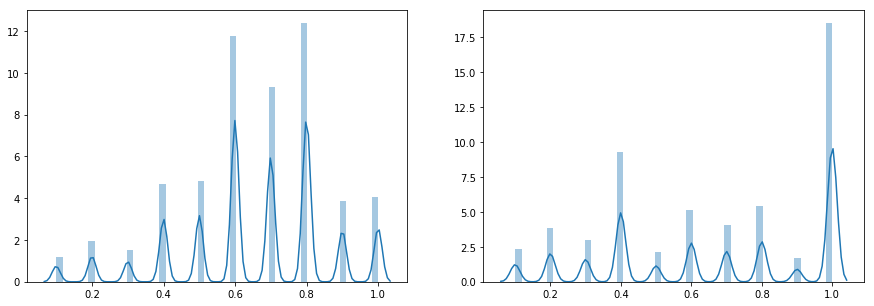

In [26]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(R[train_idx])
plt.subplot(122)
sns.distplot(R[train_idx_resampled])

In [27]:
print('Check if resampled indices covers all the original indices: {}'.format(set(train_idx)==set(train_idx_resampled)))

Check if resampled indices covers all the original indices: True


In [0]:
#ind = train_idx
ind = train_idx_resampled

train_dataset = torch.utils.data.TensorDataset(
    U[ind], M[ind], R[ind])

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle = True)

In [0]:
ind = val_idx
val_dataset = torch.utils.data.TensorDataset(
    U[ind], M[ind], R[ind])
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle = True)

## Build model

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
class NCF(nn.Module):
    def __init__(self, config):
        super(NCF, self).__init__()
        self.config = config
        self.user_dim = config['nUsers']
        self.movie_dim = config['nMovies']
        self.genres_dim = config['nGenres']
        
        self.g_latent_dim = config['genre_latent_dim']
        self.u_latent_dim = config['user_latent_dim']
        self.i_latent_dim = config['item_latent_dim']
        
        self.user_embedding = nn.Embedding(self.user_dim, self.u_latent_dim, 
                                           max_norm=1, scale_grad_by_freq = True)
        
        self.movie_embedding = nn.Embedding(self.movie_dim, self.i_latent_dim,
                                           max_norm=1, scale_grad_by_freq = True)

        self.genres_layers = nn.Sequential(
                                nn.Linear(self.genres_dim, self.g_latent_dim)
        )
        
        self.fc_layers_relevance = nn.Sequential(
            nn.Linear(self.g_latent_dim + self.i_latent_dim + 64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
        self.cos_sim = nn.CosineSimilarity(dim=2, eps=1e-6)
        
    def forward(self, user_id, movie_id, genres, em_query):
        user_em = self.user_embedding(user_id)
        movie_em = self.movie_embedding(movie_id)
        genres_em = self.genres_layers(genres)
        
        final_query_em = user_em + genres_em + em_query
        
        relevance_em = torch.cat((movie_em, genres_em, em_query), dim=2)
        relevance_em = relevance_em.view(-1,self.g_latent_dim + self.i_latent_dim + 64)

        relevance_score = self.fc_layers_relevance(relevance_em)

        return relevance_score.view(-1,1), torch.bmm(final_query_em, movie_em.view(-1,self.i_latent_dim, 1)).view(-1,1)

In [32]:
config = {'nUsers': nU, 'nMovies': nM, 
          'nGenres': len(genres_list),
          'user_latent_dim': 64, 'item_latent_dim': 64,
          'genre_latent_dim': 64
         }
print(config)


{'nUsers': 4380, 'nMovies': 3868, 'nGenres': 22, 'user_latent_dim': 64, 'item_latent_dim': 64, 'genre_latent_dim': 64}


In [0]:
CF = NCF(config).to(device)

In [0]:
CF_criterion = nn.MSELoss()
CF_relevance_criterion = nn.BCELoss()

CF_optimizer = torch.optim.Adam(CF.parameters(), lr = 0.001, betas = (0.5, 0.999))

In [35]:
count_parameters(CF)

541761

/usr/local/lib/python3.6/dist-packages/torch/onnx/utils.py:586: UserWarning: ONNX export failed on ATen operator embedding_renorm because torch.onnx.symbolic.embedding_renorm does not exist
  .format(op_name, op_name))


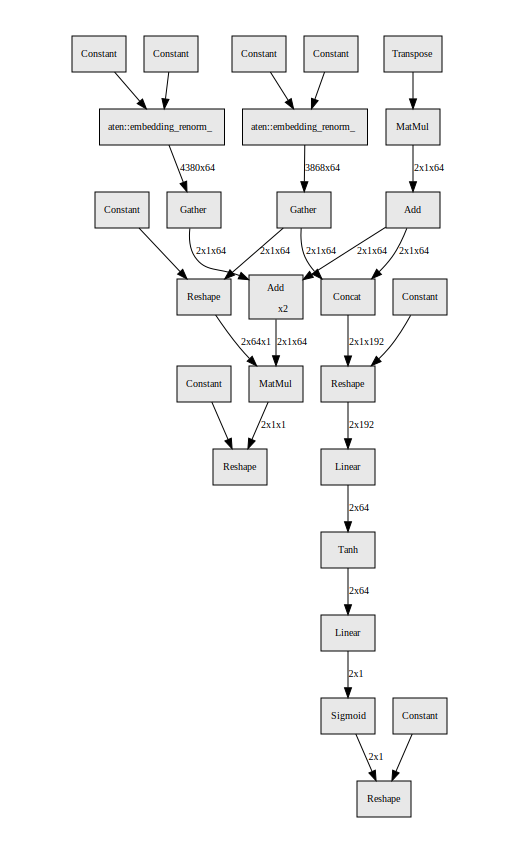

In [36]:
hl.build_graph(CF, (torch.LongTensor(np.zeros((2,1))).to(device), #uids
   torch.LongTensor(np.zeros((2,1))).to(device), #mids
   torch.FloatTensor(np.zeros((2,1,len(genres_list)))).to(device), #gids
   torch.FloatTensor(np.zeros((2,1,64))).to(device)#query
   )) #hr


In [37]:
CF(torch.LongTensor(np.zeros((2,1))).to(device), #uids
   torch.LongTensor(np.zeros((2,1))).to(device), #mids
   torch.FloatTensor(np.zeros((2,1,len(genres_list)))).to(device), #gids
   torch.FloatTensor(np.zeros((2,1,64))).to(device)#query
   ) #hr


(tensor([[0.4774],
         [0.4774]], device='cuda:0', grad_fn=<ViewBackward>),
 tensor([[-0.1719],
         [-0.1719]], device='cuda:0', grad_fn=<ViewBackward>))

## Training

In [0]:
class progress():
    def __init__(self,max = 100):
        self.mrange = max
        self.pbar = display(self.progress(0,M=self.mrange, loss_score=0, loss_relevance=0), display_id = True)

    def update(self, i, loss_score=0, loss_relevance=0):
        self.pbar.update(self.progress(i,M=self.mrange, loss_score=loss_score, loss_relevance=loss_relevance))
    
    def progress(self, value, loss_score=0, loss_relevance=0, M=100):
        return HTML("""Training Mini Batch [{value}/{M}] Loss [rating={loss_score:0.5f}, relevance={loss_relevance:0.5f}] <progress
                value='{value}'
                max='{M}',
                style='width: 80%'
            >
                90
            </progress>
              """.format(value=value, M=M, loss_score=loss_score, loss_relevance=loss_relevance))

In [39]:
nBatch_train = train_loader.__len__()
nBatch_val = val_loader.__len__()

print('{} mini-batches in training dataset, {} mini-batches in validation dataset'.format(nBatch_train, nBatch_val))

1681 mini-batches in training dataset, 83 mini-batches in validation dataset


In [0]:
epoch_num = 50

In [0]:
def lr_schedular(optimizer, epoch):
    if(epoch<2):
        lr = 0.002
    elif(epoch<10):
        lr = 0.001
    elif (epoch<20):
        lr = 0.0005
    else:
        lr = 0.00025

    for param_group in optimizer.param_groups:
        param_group['lr']=lr

    return optimizer

In [0]:
G = G.to(device)

In [0]:
def get_irrelevant_movies(movies):
#     res = torch.clone(movies)
#     for i, m in enumerate(movies):
#         j0 = m.item()
#         j = j0
#         while(j==j0):
#             j = random.sample(range(nM),1)[0]
#             print(j)
#         res[i,0] = j
    res = np.random.choice(nM, movies.shape[0], replace=True)
    return torch.LongTensor(res).view(movies.shape)

In [0]:
def get_query_tensor(movieIds):
    
    def get_embedding(kw_list):
        if len(kw_list)==0:
            return kw_default_embedding
        else:
            res = torch.zeros(kw_default_embedding.shape)
            for kw in kw_list:
#                if kw in kw_set:
                res+=kw_embedding[kw]
            return res/len(kw_list)

    res = []
    for i in movieIds.detach().cpu().numpy().flatten():
        kws = random.sample(kw_by_movie[i], random.randrange(len(kw_by_movie[i])))
        res.append(get_embedding(kws))

    return torch.cat(res,dim=0).to(device)

In [78]:
train_losses = []
train_rating_losses = []
train_relevance_losses = []

val_losses = []
val_rating_losses = []
val_relevance_losses = []


for epoch in range(epoch_num):
    
    #torch.save(CF.state_dict(), os.path.join(savepath,'cfmodel'))

    print('Training epoch {}/{}'.format(epoch, epoch_num))
    pbar = progress(train_loader.__len__())
    
    CF_optimizer = lr_schedular(CF_optimizer, epoch)

    CF.train()
    
    for i,(users, movies, ratings) in enumerate(train_loader):
        if i%5==0:
            pbar.update(i+1, tmp_loss_rating, tmp_loss_relevance)

        U, I, R = users.to(device), movies.to(device), ratings.to(device)
        irrelevant_movie = get_irrelevant_movies(movies)
        Q = get_query_tensor(movies)
        Q_irrelevant = get_query_tensor(irrelevant_movie)

        rel_score, rhat = CF(U, I, G[movies], Q)
        irrel_score, _ = CF(U, I, G[irrelevant_movie], Q_irrelevant)

        loss_rating = CF_criterion(rhat, R)
        
        loss_relevance = CF_relevance_criterion(rel_score, torch.ones(rel_score.shape).to(device)) + \
                         CF_relevance_criterion(irrel_score, torch.zeros(rel_score.shape).to(device)) 
        
        loss = 10*loss_rating + loss_relevance
        
        CF_optimizer.zero_grad()
        
        loss.backward()
        
        CF_optimizer.step()
        
        train_losses.append(loss.item())
        train_rating_losses.append(loss_rating.item())
        train_relevance_losses.append(loss_relevance.item())
        
    CF.eval()
    for i, (u,m,r) in enumerate(val_loader):
        U, I, R = u.to(device), m.to(device), r.to(device)
        irrelevant_movie = get_irrelevant_movies(m)
        Q = get_query_tensor(m)
        Q_irrelevant = get_query_tensor(irrelevant_movie)

        rel_score, rhat = CF(U, I, G[m], Q)
        irrel_score, _ = CF(U, I, G[irrelevant_movie], Q_irrelevant)

        loss_rating = CF_criterion(rhat, R)
        
        loss_relevance = CF_relevance_criterion(rel_score, torch.ones(rel_score.shape).to(device)) + \
                         CF_relevance_criterion(irrel_score, torch.zeros(rel_score.shape).to(device)) 
        
        loss = loss_rating + loss_relevance

        val_losses.append(loss.item())
        val_rating_losses.append(loss_rating.item())
        val_relevance_losses.append(loss_relevance.item())
    
    print('epoch[{}/{}], train loss = {}, val loss = {}'.
         format(epoch, epoch_num, train_loss, val_loss))
    
    if (epoch%1==0):
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(train_losses, label='train loss')
        plt.xlabel('# batch'), plt.ylabel('loss'), plt.legend(), plt.yscale('log')
        plt.subplot(122)
        plt.plot(val_losses, label='val loss')
        plt.xlabel('# batch'), plt.ylabel('loss'), plt.legend(), plt.yscale('log')
        plt.show()

Training epoch 0/50


NameError: ignored

In [250]:
CF.eval()
torch.save(CF.state_dict(), './cfmodel_v0.4')
torch.save(CF.state_dict(), os.path.join(savepath,'cfmodel_v0.4'))

RuntimeError: ignored

In [0]:
Movie_Em = CF.movie_embedding.weight.data.detach().cpu().numpy()
User_Em = CF.user_embedding.weight.data.detach().cpu().numpy()

In [0]:
ave_User_Em = User_Em.mean(axis=0, keepdims=True)

In [0]:
with open('./movie_embedding', 'wb') as f:
    pickle.dump(Movie_Em, f)
with open('./ave_user_embedding', 'wb') as f:
    pickle.dump(ave_User_Em, f)


NameError: ignored

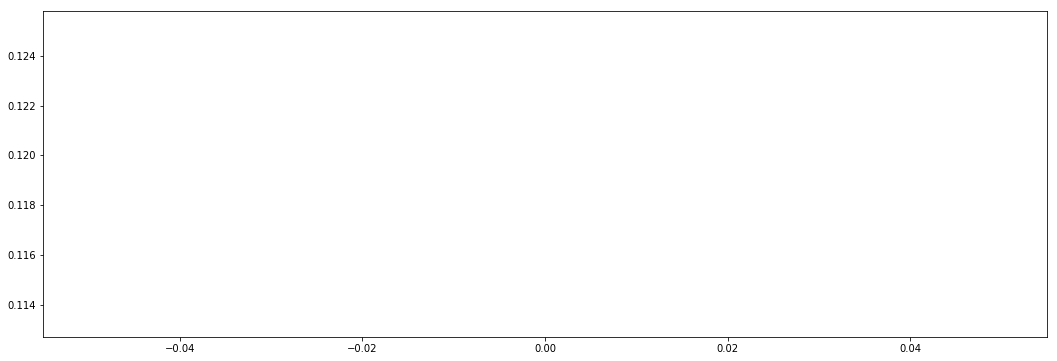

In [89]:
plt.figure(figsize=(18,6))

plt.plot(np.linspace(0,epoch-1, len(train_losses)),train_losses,label='train_loss')
plt.plot(np.linspace(0,epoch-1, len(train_rating_losses)),train_rating_losses,label='train_loss(rating)')
plt.plot(np.linspace(0,epoch-1, len(train_relevance_losses)),train_relevance_losses,label='train_loss(relevance)')
plt.plot(np.linspace(0,epoch-1, len(val_losses)),val_losses,label='val_loss')
plt.plot(np.linspace(0,epoch-1, len(val_rating_losses)),val_rating_losses,label='val_rating_loss')
plt.plot(np.linspace(0,epoch-1, len(val_relevance_losses)),val_relevance_losses,label='val_relevance_loss')
plt.yscale('log')
plt.legend(),plt.xlabel('epoch'), plt.ylabel('loss')
plt.grid(True)
#plt.ylim([0.01,0.05])

In [90]:
r_real = []
r_pred = []

n_tp = 0
n_tn = 0
n_fp = 0
n_fn = 0


with torch.no_grad():
    for i, (u, m,r) in enumerate(val_loader):
        U, I, R = u.to(device), m.to(device), r.to(device)
        irrelevant_movie = get_irrelevant_movies(m)
        Q = get_query_tensor(m)
        Q_irrelevant = get_query_tensor(irrelevant_movie)

        rel_score, rhat = CF(U, I, G[m], Q)
        irrel_score, _ = CF(U, I, G[irrelevant_movie], Q_irrelevant)

        r_real+=list(r.detach().cpu().numpy().reshape(-1))
        r_pred+=list(rhat.detach().cpu().numpy().reshape(-1))
        
        rel_score = rel_score.detach().cpu().numpy().flatten()
        irrel_score = irrel_score.detach().cpu().numpy().flatten()
        
        n_tp += np.sum(rel_score>0.5)
        n_tn += np.sum(irrel_score<0.5)
        n_fp += np.sum(irrel_score>0.5)
        n_fn += np.sum(rel_score<0.5)
        
        if(i%20==0):
            print('{}/{}'.format(i,nBatch_val))

0/83
20/83
40/83
60/83
80/83


In [91]:
print('           | predict relevant  |  predict irrelevant')
print('relevant   |   %5d           |     %5d          ' % (n_tp, n_fn))
print('irrelevant |   %5d           |     %5d          ' % (n_fp, n_tn))

precision = n_tp/(n_tp+n_fp)
recall = n_tp/(n_tp+n_fn)
print('precision = %f' % precision)
print('recall = %f' % recall)

print('F1-score = %f' % (2/(1/precision+1/recall)))

           | predict relevant  |  predict irrelevant
relevant   |   333989           |      1918          
irrelevant |    5883           |     330024          
precision = 0.982691
recall = 0.994290
F1-score = 0.988456


In [0]:
r_real = np.array(r_real) #, dtype=np.int)
r_pred = np.array(r_pred) #, dtype=np.int)
e = r_pred - r_real

In [0]:
r_pearson = scipy.stats.pearsonr(r_real, r_pred)[0]
r_spearman = scipy.stats.spearmanr(r_real, r_pred).correlation
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_real, r_pred)

In [94]:
print('average error = {}, std = {}'.format(e.mean(), e.std()))
print('mae = {}'.format(np.abs(e).mean()))
print('rmse = {}'.format(np.sqrt(np.square(e).mean())))

print('slope={}, r2={}'.format(slope, r_value))
print('pearson = {}, spearman = {}'.format(r_pearson, r_spearman))

average error = -0.04071928188204765, std = 0.17661480605602264
mae = 0.141172394156456
rmse = 0.1812480092048645
slope=0.6132780532545926, r2=0.6309463152946633
pearson = 0.6309463152946642, spearman = 0.6230317585797558


(Text(0.5, 0, 'predict error'), Text(0, 0.5, 'count'))

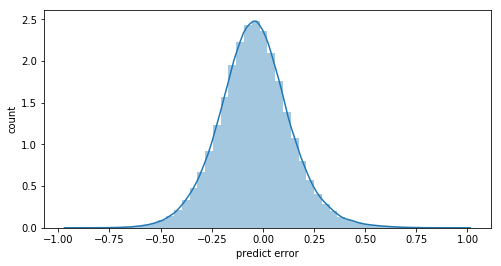

In [95]:
plt.figure(figsize=(8,4))
sns.distplot(r_pred-r_real, kde=True)
plt.xlabel('predict error'), plt.ylabel('count')

In [0]:
real = r.view(-1).detach().cpu().numpy()
pred = rhat.view(-1).detach().cpu().numpy()
users = U.detach().cpu().numpy().reshape(-1)
movies = I.detach().cpu().numpy().reshape(-1)
pd_df = pd.DataFrame({'real': real,'pred':pred, 'userId': users, 'movieId': movies})
pd_df = pd_df.merge(movie_df, how='left', on='movieId')
pd_df = pd_df.merge(user_df, how='left', on='userId')
#pd_df = pd_df.drop(columns = ML_Data.movie_genres)

In [97]:
pd_df.head(50)

,real,pred,userId,movieId,index,Unnamed: 0,title,qmdbId,tmdbId,year,genre_kws,kws_all,num_rating,movie_ave_rating,movie_std_rating,num_movie_rated,user_ave_rating,user_std_rating
0,0.5,0.503311,2311,2544,896.0,896.0,Any Given Sunday,896.0,9563.0,1999.0,drama,oliver dennis stadium oliver terrible diaz giv...,1319.0,3.017058,0.905583,755,2.968874,0.811896
1,0.6,0.578376,571,1556,565.0,565.0,Metropolis,565.0,19.0,1927.0,"fiction,science,drama",man a deco and sci fi incoherent mad than work...,1362.0,3.902717,0.935801,855,2.907602,0.672477
2,0.6,0.556105,1612,851,258.0,258.0,Sleeper,258.0,11561.0,1973.0,"science,fiction,comedy,romance",sleeper independent 100 ironic strong control ...,1300.0,3.674231,0.896399,527,3.232448,0.861376
3,0.5,0.598953,3969,759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,492,3.783537,0.720936
4,0.8,0.698242,2616,1666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,712,3.904494,0.657645
5,0.6,0.673272,1298,3806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,845,3.172781,0.788900
6,0.6,0.648827,2091,2635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1091,3.323556,0.910078
7,0.8,0.916012,4098,2673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,935,3.782888,0.766277
8,0.4,0.300294,1346,1787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,587,2.863714,1.342783
9,0.6,0.251381,3185,1828,640.0,640.0,American History X,640.0,73.0,1998.0,drama,x tragedy and super beverly swastika camera he...,3103.0,3.967934,0.832442,786,2.483461,1.286275


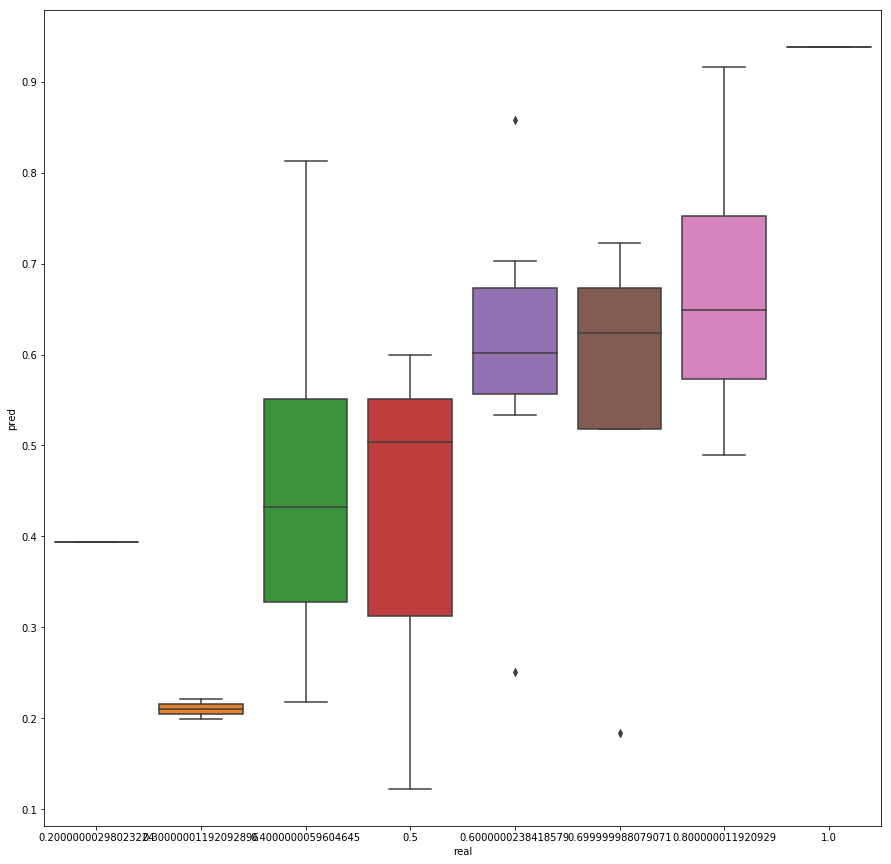

In [98]:
plt.figure(figsize=(15,15))
sns.categorical.boxplot(x="real", y="pred", data=pd_df)

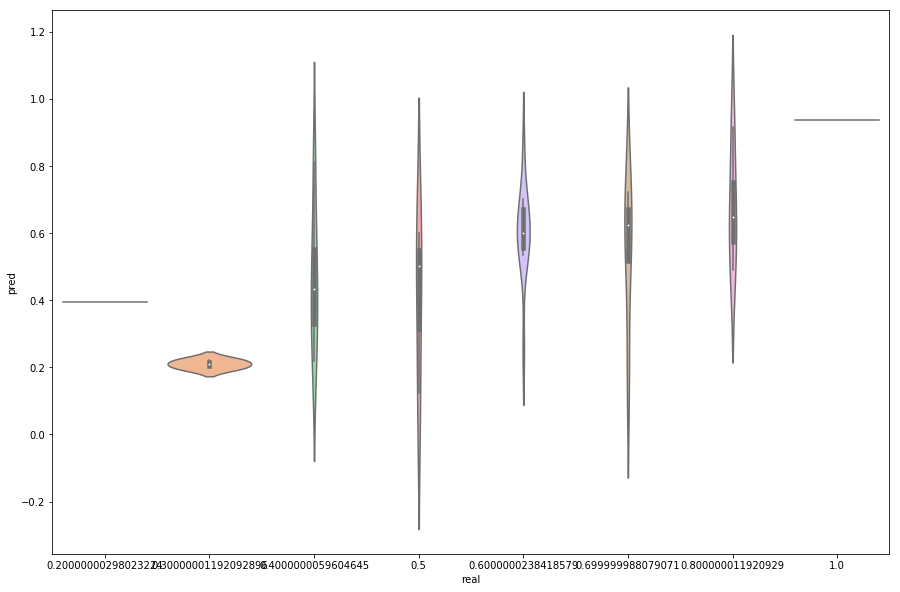

In [99]:
plt.figure(figsize=(15,10))
sns.categorical.violinplot(x="real", y="pred", split=True,  data=pd_df, palette="pastel")


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


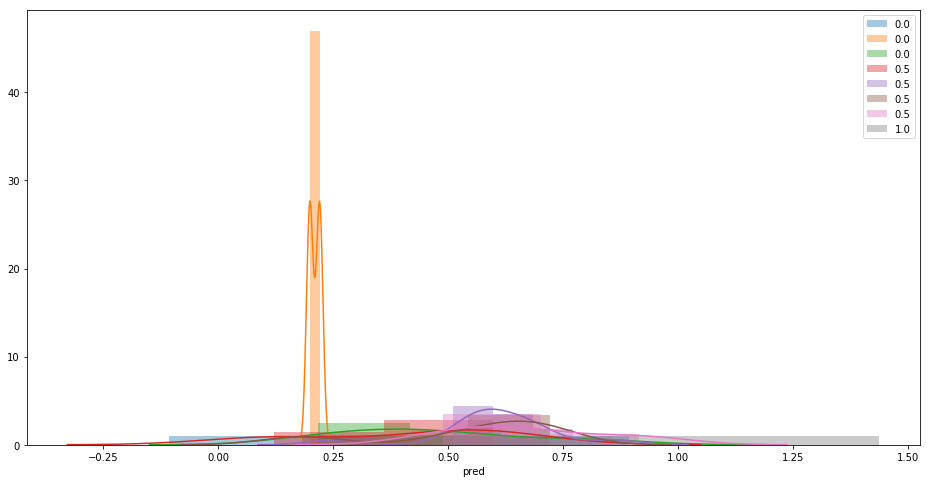

In [100]:
rs = list(pd_df['real'].unique())
rs.sort()
plt.figure(figsize=(16,8))
for r in rs:
    sns.distplot(pd_df['pred'][pd_df['real']==r], label=str(int(r*2)/2))
plt.legend()

In [0]:
genre_weight = CF.genres_layers[0].weight.detach().cpu().numpy().T

pca = decomposition.PCA(n_components = 5)
G_std = StandardScaler().fit_transform(genre_weight)
G_pca = pca.fit_transform(G_std)

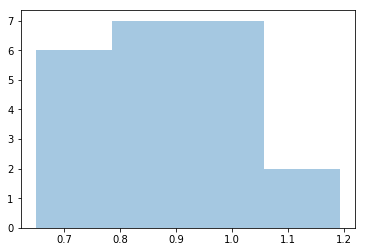

In [102]:
L = np.linalg.norm(genre_weight,axis=1,keepdims=True)
sns.distplot(L,kde=False)

(-5.3840203, 7.750207)

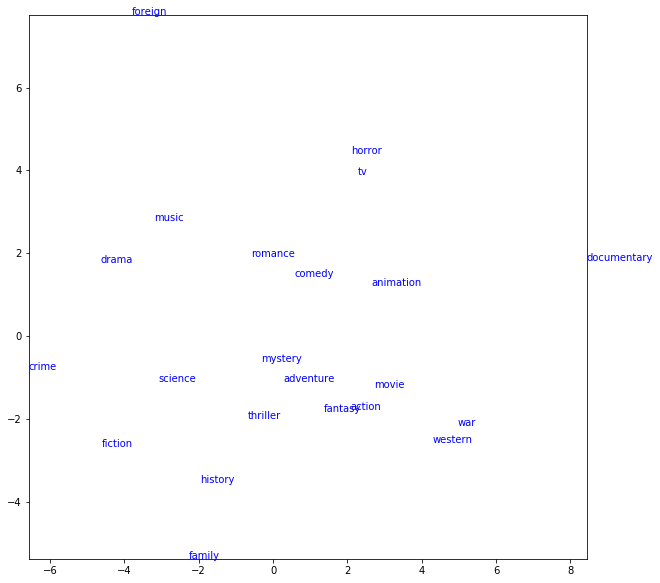

In [103]:
plt.figure(figsize=(10,10))

xs = []
ys = []

for key in genres_dict:
    i = genres_dict[key]
    x,y = G_pca[i,0], G_pca[i,1]
    xs+=[x]
    ys+=[y]
    plt.text(x,y,key,color='b', fontsize=10)

plt.xlim([min(xs),max(xs)])
plt.ylim([min(ys),max(ys)])

In [0]:
Movie_Em = CF.movie_embedding.weight.data.detach().cpu().numpy()

In [0]:
L = np.linalg.norm(Movie_Em,axis=1,keepdims=True)

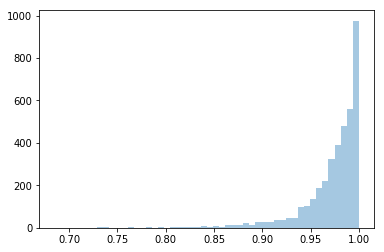

In [106]:
sns.distplot(L,kde=False)

In [0]:
pca = decomposition.PCA(n_components = 5)
M_std = StandardScaler().fit_transform(Movie_Em)
M_pca = pca.fit_transform(M_std)

(-5.774945998176849, 7.956479988220468, -5.924540572535638, 7.4441266191841144)

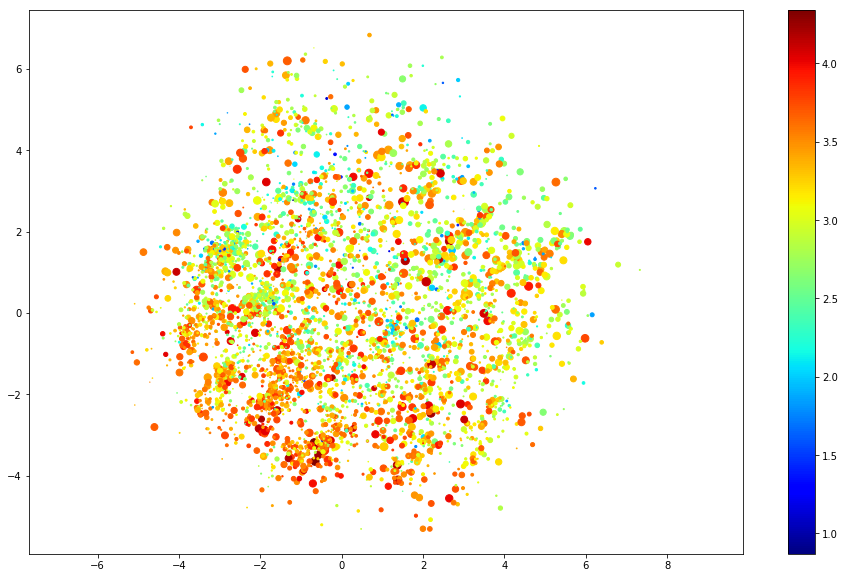

In [108]:
plt.figure(figsize=(16,10))

ss = (movie_df['num_rating'].values - movie_df['num_rating'].min())/60

plt.scatter(M_pca[:,0], M_pca[:,1], c = movie_df['movie_ave_rating'].values, s = ss, cmap='jet')
plt.colorbar()
plt.axis('equal')

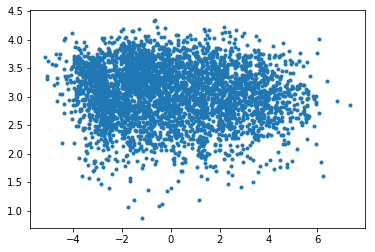

In [109]:
plt.plot(M_pca[:,0], movie_df['movie_ave_rating'],'.')

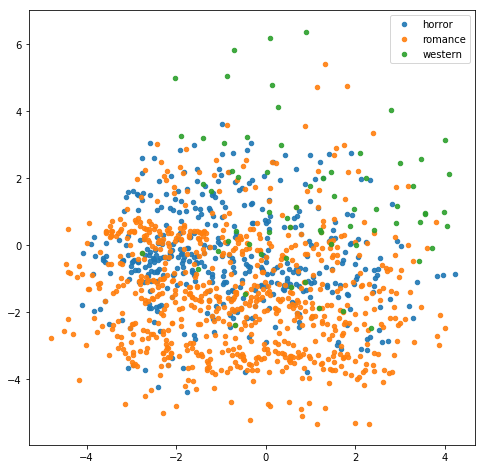

In [110]:
plt.figure(figsize=(8,8))
#for g in ML_Dataset.movie_genres:
for g in ['horror','romance','western']:
    i_g = genres_dict[g]
    ind = np.where(genres[:,i_g]==1)[0].tolist()
    plt.scatter(M_pca[ind,2], M_pca[ind,1],label=g,s=20, alpha=0.9)
plt.legend()

(-4.5610924, 6.1987557)

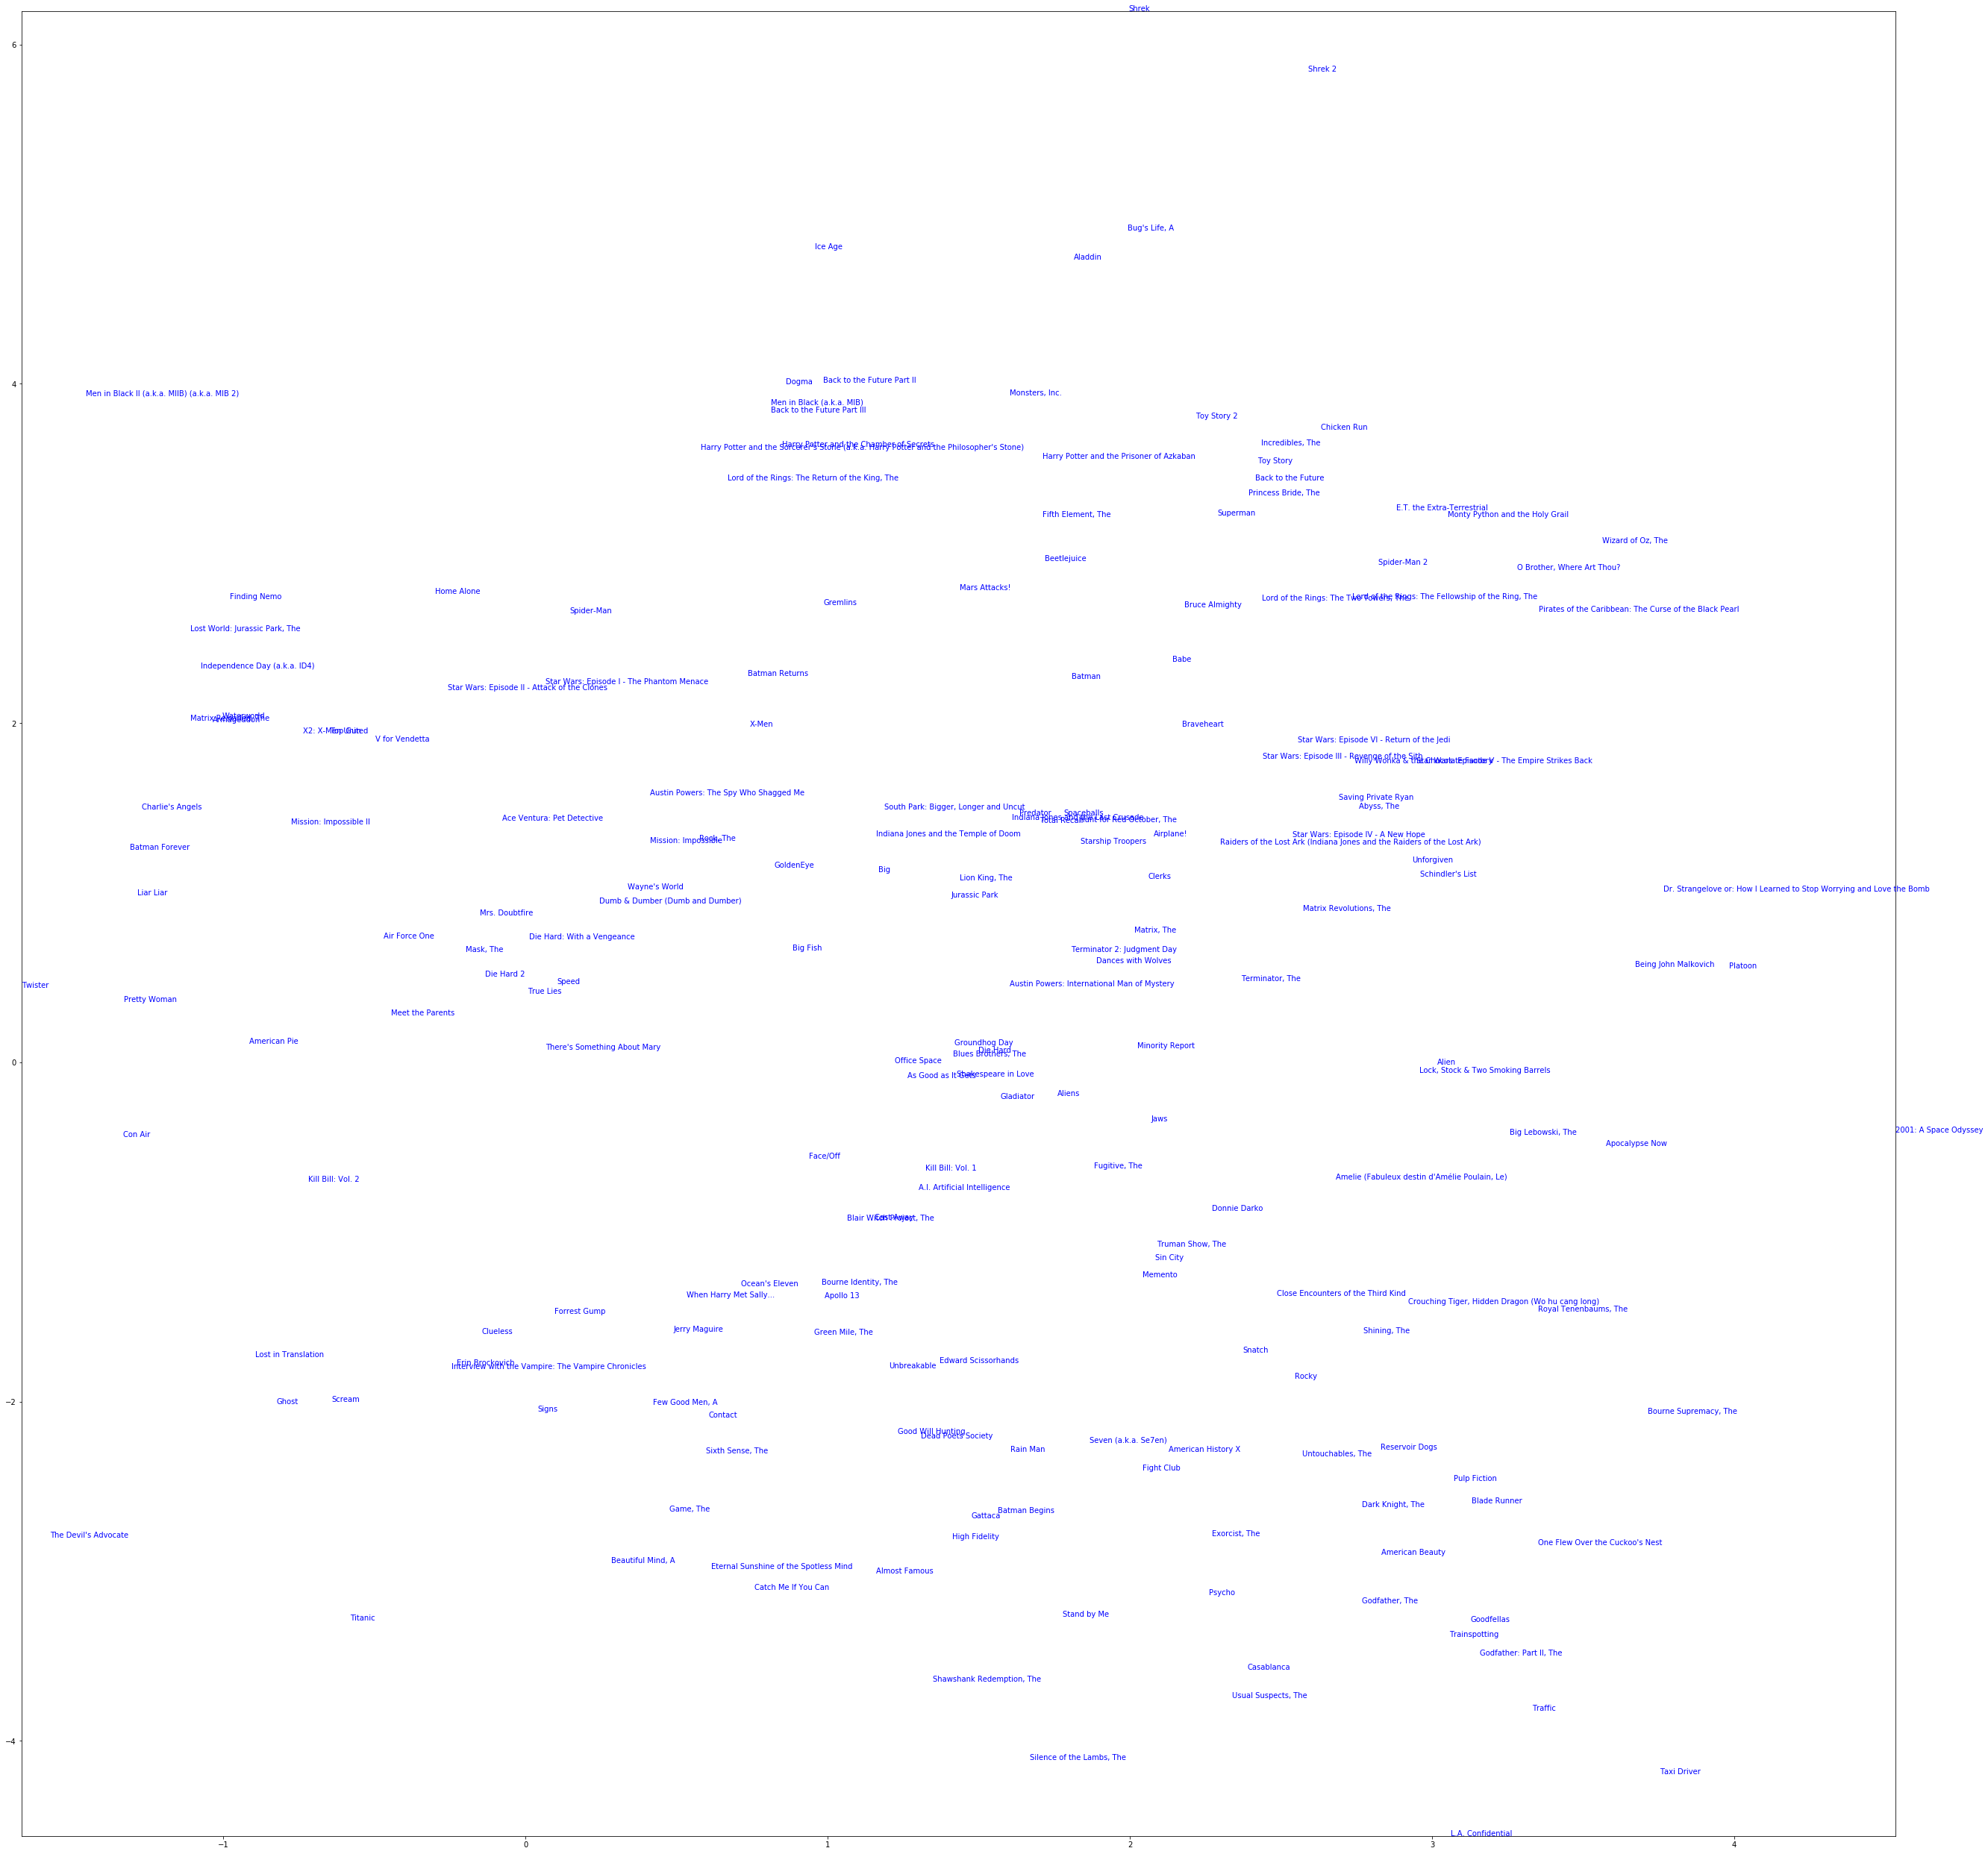

In [111]:
TopMovies_id = movie_df['num_rating'].nlargest(200).index.values

plt.figure(figsize=(45,45))
#plt.scatter(M_pca[:,0], M_pca[:,1])

xs = []
ys = []

for i in TopMovies_id:
    t = movie_df['title'][i]
    x,y = M_pca[i,2], M_pca[i,1]
    xs+=[x]
    ys+=[y]
    #if(x>xlim[0] and x<xlim[1] and y>ylim[0] and y<ylim[1]):
    plt.text(x,y,t,color='b', fontsize=10)

plt.xlim([min(xs),max(xs)])
plt.ylim([min(ys),max(ys)])

In [0]:
Movie_Em = Movie_Em/L

In [0]:
Movie_S = np.matmul(Movie_Em, Movie_Em.T)

In [114]:
for i in range(50):
    movie_id = TopMovies_id[i]
    t = movie_df['title'][movie_id]
    print('Movie:'+t)
    
    tmp_S = Movie_S[movie_id]
    tmp_ids = tmp_S.argsort()[::-1]
    n = 0
    for tmp_id in tmp_ids[1:]:
        if(movie_df['movie_ave_rating'][tmp_id]>0.0):
            t = movie_df['title'][tmp_id]
            print('  ',t)
            n+=1
        if (n>10):
            break
    print()

Movie:Matrix, The
   Terminator 2: Judgment Day
   Total Recall
   Attack the Block
   Terminator, The
   Memento
   Die Hard
   Spider-Man
   Speed
   Italian Job, The
   X-Men
   Signal, The

Movie:Forrest Gump
   Rain Man
   Shawshank Redemption, The
   Good Will Hunting
   Green Mile, The
   Dead Poets Society
   Apollo 13
   Wrestler, The
   Few Good Men, A
   Beautiful Mind, A
   Nine
   Mr. Holland's Opus

Movie:Back to the Future
   Back to the Future Part II
   Back to the Future Part III
   E.T. the Extra-Terrestrial
   Iron Giant, The
   Galaxy Quest
   Toy Story
   Hot Tub Time Machine
   Jurassic Park
   Bill & Ted's Excellent Adventure
   Shrek 2
   Batman

Movie:Pulp Fiction
   Reservoir Dogs
   Goodfellas
   Snatch
   Silence of the Lambs, The
   Usual Suspects, The
   Trainspotting
   Punisher, The
   Godfather: Part II, The
   Godfather, The
   L.A. Confidential
   Scarface

Movie:Jurassic Park
   Terminator 2: Judgment Day
   Independence Day (a.k.a. ID4)
   Star War

In [0]:
movie_embedding = CF.movie_embedding.weight.data.detach().cpu().numpy()
user_embedding = CF.user_embedding.weight.data.detach().cpu().numpy()

In [0]:
genres_weight = CF.genres_layers[0].weight.data.detach().cpu().numpy()
genres_bias = CF.genres_layers[0].bias.data.detach().cpu().numpy()

In [0]:
fc_relevance = [{},{}]
for ilayer in range(2):
    fc_relevance[ilayer]['weight'] = CF.fc_layers_relevance[ilayer*2].weight.data.detach().cpu().numpy()
    fc_relevance[ilayer]['bias'] = CF.fc_layers_relevance[ilayer*2].bias.data.detach().cpu().numpy()
    

In [0]:
kw_embedding_np = dict((k,v.detach().cpu().numpy()[0][0]) for (k,v) in kw_embedding.items())

In [126]:
kw_default_embedding.shape

torch.Size([1, 1, 64])

In [0]:
model_weights = {'genres_weight':genres_weight,
                'genres_bias':genres_bias,
                'genres_list': genres_list,
                'genres_dict': genres_dict,
                'movie_embedding': movie_embedding,
                'fc_relevance': fc_relevance,
                 'kw_embedding': kw_embedding_np,
                 'kw_default_embedding': kw_default_embedding[0][0].detach().numpy(),
                 'kw_set': kw_set                 
                }

In [0]:
def get_query_vector(query, model_weights):
    kws = [kw.lower() for kw in query.split(' ')]
    n = 0
    res = np.zeros(64)
    for kw in kws:
        if kw in model_weights['kw_set']:
            print(kw)
            res+=model_weights['kw_embedding'][kw]
            n+=1
    if n==0:
        return model_weights['kw_default_embedding']
    else:
        return res/n

In [0]:
def get_genre_vector(genres, model_weights):
    v = np.zeros((22,1))
    for g in genres:
        if g in model_weights['genres_dict']:
            v[model_weights['genres_dict'][g]]=1
    
    return model_weights['genres_weight'].dot(v).squeeze(1)+model_weights['genres_bias']

In [0]:
def predict(model_weights, query, user_embedding, genres):

    query_embedding = get_query_vector(query, model_weights)
    genres_embedding = get_genre_vector(genres_q, model_weights)

    final_query_em = ave_User_Em + genres_embedding + query_embedding

    relevance_em = np.concatenate((model_weights['movie_embedding'], genres_embedding.reshape(1,64).repeat(nM,axis=0), query_embedding.reshape(1,64).repeat(nM,axis=0)),axis=1)

    for i, fc in enumerate(model_weights['fc_relevance']):
        relevance_em = relevance_em.dot(fc['weight'].T)+fc['bias']
        if i==0:
            relevance_em = np.tanh(relevance_em)
        else:
            relevance_em = 1. / (1. + np.exp(-relevance_em))

    relevance_score = relevance_em.squeeze(axis=1)
    rating_score = final_query_em.dot(model_weights['movie_embedding'].T).squeeze(0)
    
    return relevance_score, rating_score

In [0]:
query = 'toy story'
genres_q = ['family','animation']

In [245]:
rel, rat = predict(model_weights, query, ave_User_Em, genres_q)

toy
story


In [0]:
ind_rel = np.argsort(rel)[::-1][:200]
ind = [ind_rel[i] for i in np.argsort(rating_score[ind_rel])[::-1]]

In [248]:
movie_df.iloc[list(ind)]

,index,Unnamed: 0,title,movieId,qmdbId,tmdbId,year,genre_kws,kws_all,num_rating,movie_ave_rating,movie_std_rating
893,893,893,Fantasia 2000,2534,893,49948,1999,"family,music,animation",vhs etaege j music earl animals disney perlman...,903,3.352159,0.999453
3119,3119,3119,Kung Fu Panda 2,8930,3120,49444,2011,"family,animation",animation woman much yuh jennifer panda black ...,797,3.227102,0.943035
2434,2434,2434,Rescue Dawn,7605,2435,9952,2006,"war,adventure,drama",cazador lrc lived bale marshall letter millor ...,695,3.508633,0.700399
105,105,105,"Lion King, The",321,105,8587,1994,"family,drama,animation",zimmer and super shaman jeremy gary tzudiker l...,3463,3.671383,0.942763
261,261,261,Platoon,864,261,792,1986,"action,war,drama",scenes 100 realistic btaege willem ses cameo o...,2796,3.822604,0.827201
929,929,929,"Tigger Movie, The",2633,929,15655,2000,"family,animation",animation woman tigger animals disney the anim...,306,2.779412,1.011994
3573,3573,3573,Space Pirate Captain Harlock,9743,3574,192577,2013,"fiction,science,animation",aoi captain shinji sci fi space yu pirate aram...,51,2.960784,1.038476
2606,2606,2606,WALL·E,7940,2607,10681,2008,"family,animation",man touching r sci fi isolation space versus k...,2442,3.938165,0.865650
2505,2505,2505,Enchanted,7755,2506,4523,2007,"comedy,family,fantasy,romance",adams r nyc self referential scene toplist07 q...,1073,3.373253,0.926276
322,322,322,Fantasia,1017,322,756,1940,"family,music,animation",100 julietta satterfield than more once surrea...,2208,3.643569,1.009019
